# Pipeline
Для обучения любой модели можно придерживаться такого плана
- Подготовка датасета (поиск данных, группировка, трансформация)
- Создание Dataloader - загрузчика данных
- Создание архитектуры модели
- Создание оптимизатора, функции ошибки, метрик
- Цикл обучения и валидации


In [ ]:
!pip install torchmetrics

In [ ]:
import torch, torchmetrics
import torch.nn as nn
import torchvision as tv
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from tqdm.autonotebook import tqdm

In [3]:
trans = tv.transforms.Compose([
   tv.transforms.ToTensor()
])

In [ ]:
ds_mnist = tv.datasets.MNIST('./datasets', download=True, transform=trans)

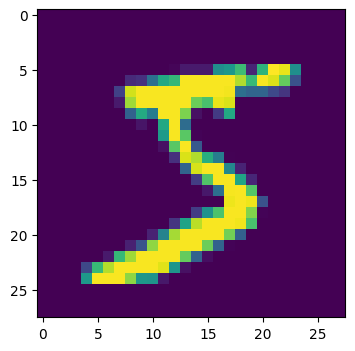

In [5]:
plt.figure(figsize=(4,4))
plt.imshow(ds_mnist[0][0].numpy()[0])

In [6]:
batch_size = 16
dataloader = torch.utils.data.DataLoader(
    ds_mnist, batch_size=batch_size, shuffle=True,
    num_workers=1, drop_last=True
)

In [8]:
for img, label in dataloader:
  print(img.shape)
  print(label.shape)
  break

# в torch принята BCHW батчи-каналы-высота-ширина
# в других библиотеках принято HWC
# правильное преобразование HWC -> CHW (dataset) -> BCHW (dataloader)

torch.Size([16, 1, 28, 28])
torch.Size([16])


In [10]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(28*28, 100)
    self.linear2 = nn.Linear(100, 10)
    self.relu = nn.ReLU()

  def forward(self, x):
    out = self.flatten(x)
    out = self.linear1(out)
    out = self.relu(out)
    out = self.linear2(out)
    return out

model = Net()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [11]:
def count_params(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_params(model)

79510

In [12]:
def accuracy(pred, label):
  answer = torchmetrics.functional.accuracy(pred.argmax(1),
                                            label, 'multiclass',
                                            num_classes=10)
  return answer


In [ ]:
epochs = 3

for epoch in range(epochs):
  loss_val = 0
  acc_val = 0
  for img, lable in (pbar := tqdm(dataloader)):
    optimizer.zero_grad()
    lable = F.one_hot(lable, 10).float()
    model.train()
    pred = model(img)
    loss = loss_function(pred, lable)
    loss.backward()
    loss_item = loss.item()
    loss_val += loss_item
    optimizer.step()
    acc_current = accuracy(pred, label)
    acc_val += acc_current

    pbar.set_description(f'loss: {loss_item: .4f}\taccuracy: {acc_current: .4f}')
  print(loss_val/len(dataloader))
  print(acc_val/len(dataloader))
